In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta*(2*Euv)
        self.beta = (1-eta)*self.beta + eta*(Ev)
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o
    
class CNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

In [3]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = Net(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run %d" % (1))
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = Net(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run %d" % (1))
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = Net(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = Net(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for shallow networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Test

In [4]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


Training IP Net. Run 1
[1] loss: 0.315
[2] loss: 0.181
[3] loss: 0.144
[4] loss: 0.124
[5] loss: 0.110
[6] loss: 0.099
[7] loss: 0.090
[8] loss: 0.084
[9] loss: 0.080
[10] loss: 0.075
[11] loss: 0.071
[12] loss: 0.065
[13] loss: 0.062
[14] loss: 0.059
[15] loss: 0.057
[16] loss: 0.053
[17] loss: 0.050
[18] loss: 0.053
[19] loss: 0.046
[20] loss: 0.045
Finished training!

Training Standard Net. Run 1
[1] loss: 0.355
[2] loss: 0.259
[3] loss: 0.244
[4] loss: 0.254
[5] loss: 0.234
[6] loss: 0.241
[7] loss: 0.235
[8] loss: 0.238
[9] loss: 0.231
[10] loss: 0.234
[11] loss: 0.219
[12] loss: 0.235
[13] loss: 0.211
[14] loss: 0.216
[15] loss: 0.221
[16] loss: 0.217
[17] loss: 0.213
[18] loss: 0.225
[19] loss: 0.215
[20] loss: 0.218
Finished training!

Training IP Net. Run 2
[1] loss: 0.313
[2] loss: 0.177
[3] loss: 0.145
[4] loss: 0.126
[5] loss: 0.112
[6] loss: 0.104
[7] loss: 0.093
[8] loss: 0.089
[9] loss: 0.081
[10] loss: 0.076
[11] loss: 0.073
[12] loss: 0.065
[13] loss: 0.067
[14] loss: 

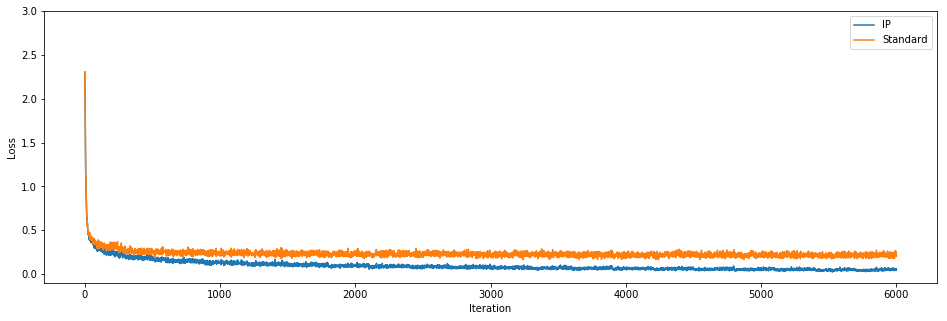

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 20

test_runs = 10

int_lr = 0.1
syn_lr = 0.03

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Test

In [4]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Training IP Net. Run 1
[1] loss: 1.933
[2] loss: 1.709
[3] loss: 1.640
[4] loss: 1.597
[5] loss: 1.563
[6] loss: 1.538
[7] loss: 1.518
[8] loss: 1.497
[9] loss: 1.482
[10] loss: 1.464
[11] loss: 1.451
[12] loss: 1.441
[13] loss: 1.428
[14] loss: 1.419
[15] loss: 1.406
[16] loss: 1.395
[17] loss: 1.386
[18] loss: 1.377
[19] loss: 1.366
[20] loss: 1.358
[21] loss: 1.349
[22] loss: 1.339
[23] loss: 1.335
[24] loss: 1.324
[25] loss: 1.320
[26] loss: 1.313
[27] loss: 1.308
[28] loss: 1.302
[29] loss: 1.294
[30] loss: 1.286
[31] loss: 1.283
[32] loss: 1.276
[33] loss: 1.270
[34] loss: 1.263
[35] loss: 1.257
[36] loss: 1.249
[37] loss: 1.251
[38] loss: 1.243
[39] loss: 1.238
[40] loss: 1.239
Finished training!

Training Standard Net. Run 1
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.312
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 

[18] loss: 2.110
[19] loss: 2.109
[20] loss: 2.086
[21] loss: 2.064
[22] loss: 2.055
[23] loss: 2.053
[24] loss: 2.048
[25] loss: 2.043
[26] loss: 2.040
[27] loss: 2.036
[28] loss: 2.037
[29] loss: 2.034
[30] loss: 2.030
[31] loss: 2.026
[32] loss: 2.023
[33] loss: 2.021
[34] loss: 2.020
[35] loss: 2.016
[36] loss: 2.017
[37] loss: 2.014
[38] loss: 2.009
[39] loss: 2.009
[40] loss: 2.003
Finished training!

Training IP Net. Run 7
[1] loss: 1.881
[2] loss: 1.700
[3] loss: 1.633
[4] loss: 1.588
[5] loss: 1.557
[6] loss: 1.534
[7] loss: 1.510
[8] loss: 1.492
[9] loss: 1.476
[10] loss: 1.460
[11] loss: 1.447
[12] loss: 1.433
[13] loss: 1.423
[14] loss: 1.413
[15] loss: 1.402
[16] loss: 1.389
[17] loss: 1.382
[18] loss: 1.370
[19] loss: 1.367
[20] loss: 1.354
[21] loss: 1.349
[22] loss: 1.338
[23] loss: 1.333
[24] loss: 1.326
[25] loss: 1.318
[26] loss: 1.308
[27] loss: 1.306
[28] loss: 1.298
[29] loss: 1.293
[30] loss: 1.283
[31] loss: 1.278
[32] loss: 1.268
[33] loss: 1.268
[34] loss: 1.2

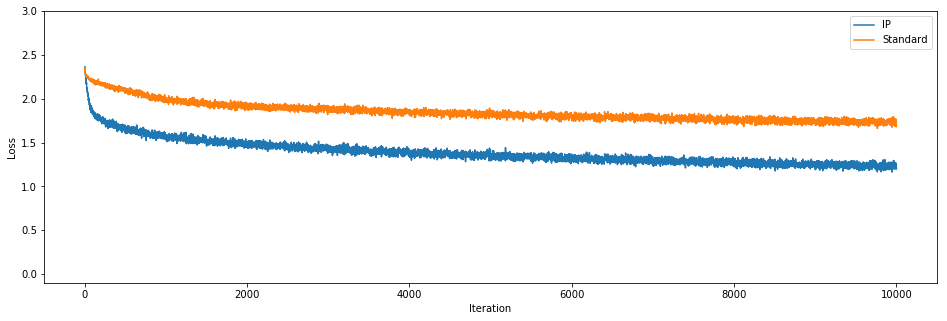

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.1
syn_lr = 0.001

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)